In [53]:
# TODO  Kolla om inflation skall ha en ratio eller inte
# TODO  ta bort absoluta värdet av inflationfrån predictors?  
# TODO: GÖr om till graf av uppåt och neråt (sök på uppåt och neråt)
# TODO  KOlla om man inte kan använda sammam create_predictors som tickers  
# TODO  Kör en GridSearchCV på alla modeller i separat program? Kolla modell i YT för loop over modeller
# TODO  Ta bort parametern remove från generate_all_models()

# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder day after tomorrows close som target   
3. Jämför CatBoost med XGBoost GridSearchCV med cross validation för tidsserier

In [54]:
import sklearn

import xgboost as xgb

import catboost
from catboost import CatBoostClassifier

# from pytrends.request import TrendReq
# import pytrends
import sys
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import plotly.express as px
import streamlit as st
# import google

from IPython.display import display
# set display witdh to 200
pd.set_option('display.width', 200)
# set display height to 500
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
# pd.options.display.precision = 4      # default 6
import logging

# Starta upp logging och inkluder rad nummer
logging.basicConfig(level=logging.INFO, filemode='w', filename='krypto.log', force=True,
                    encoding='utf-8', format= '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s')
logging.info('Startar')


In [55]:
print('Versioner av softvara som används i denna notebook:')
# print numpy version
print('numpy=={}'.format(np.__version__))
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__)) # type: ignore
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('catboost=={}'.format(catboost.__version__))

print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')



Versioner av softvara som används i denna notebook:
numpy==1.23.5
pandas==1.4.4
matplotlib==3.7.0
yfinance==0.2.12
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.14.0
xgboost==1.7.1
catboost==1.1.1
sklearn==1.0.2
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


In [56]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','XRP-USD','ZRX-USD']
horizons=[2,5,15,30,60,90,250]

In [57]:
def beräkna_rolling_mean(df, ticker_names, window=20):
    # Funktionen används inte just nu
    rolling_mean=pd.DataFrame()
    for ticker_name in ticker_names:
        df[ticker_name+'-rolling']= df[ticker_name].rolling(window=window).mean()
        
    df.dropna(inplace=True)    
    return df   

def beräkna_cumulative_return(df, ticker_names):
    # Funktionen används inte just nu
    cumulative_return={}
    for ticker_name in ticker_names:
        cumulative_return[ticker_name] = (df[ticker_name].iloc[-1]/df[ticker_name].iloc[0]-1)
    return cumulative_return

## Get inflation data US and SE

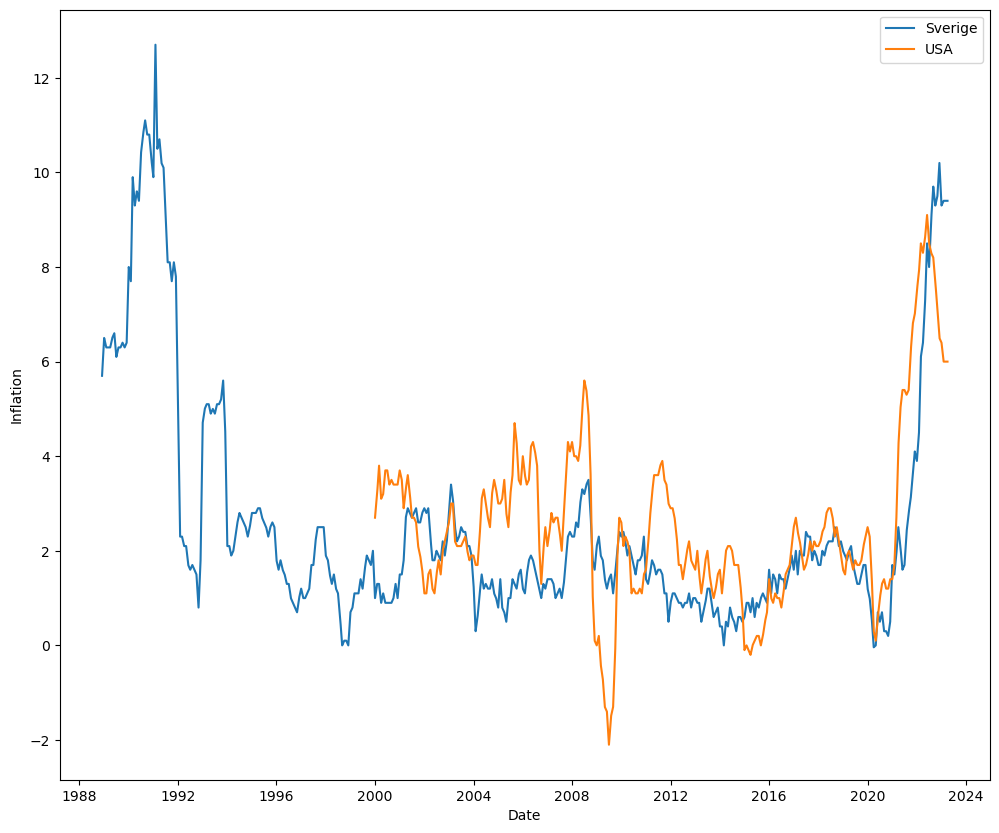

In [58]:
def add_horizon_columns(inflation, horizons):
    # print(horizons)
    for horizon in  horizons:
        # print(horizon)
        inflation['US_inflation_'+str(horizon)] = inflation['US_inflation'].rolling(horizon, 1).mean()
        inflation['SE_inflation_'+str(horizon)] = inflation['SE_inflation'].rolling(horizon, 1).mean()
                
        # print(inflation.columns)        
    return inflation


def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['date'] = pd.to_datetime(inflation['Year'].astype(str) + '-' + inflation['month'].astype(str))
    inflation.set_index('date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(inflation, how='left', left_on='date', right_index=True)
    inflation.set_index('date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


def get_inflation_data(graph=False):
    df_dates = pd.DataFrame(pd.date_range('1988-12-01', pd.to_datetime('today').date()), columns=['date'])
    
    US_inflation = pd.read_html('https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$', value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    SE_inflation = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    #
    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
    US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index, SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1)
    inflations = inflations.dropna()
    inflations = add_horizon_columns(inflations, [75,90,250])
    return inflations

inflations = get_inflation_data(graph=True)

In [59]:
display(list(inflations.columns))

['US_inflation',
 'SE_inflation',
 'US_inflation_75',
 'SE_inflation_75',
 'US_inflation_90',
 'SE_inflation_90',
 'US_inflation_250',
 'SE_inflation_250']

In [60]:
# fill up a dataframe with all days from 2015 up to today and set it as index
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


In [61]:
def fill_rolling(df, ticker_name, window):
    """ Funktionen Används inte just nu
    """

    df[ticker_name+'_tr'] = df[ticker_name].fillna(method='ffill')/30   # Basvärde att räkna från
    df[ticker_name+'_'+str(window)] = df[ticker_name+'_tr'].rolling(window, 1).mean()
    # remove column
    df.drop(ticker_name+'_tr', axis=1, inplace=True)
    
    return df

## skapa alla modellerna

In [62]:
def get_all(tickers):
    # Funktionen används inte just nu    
    df = pd.DataFrame()
    for ticker in tickers:
        # all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

df_org = get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [63]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    
    if train[target].nunique() < 2:
        print('kolumner i train',train.columns)
        print('kolumner i test',test.columns)
        print('target',target)
        print('predictors',predictors)
        print('train\n',train[target].value_counts())
        print('test\n',test[target].value_counts())
        print(
            f"Skipping training for target {target} as it has only one unique value in the training data.")
        # stäng ner programmet
        sys.exit()
        
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined


Backtest av modellerna

In [64]:
def backtest(data, target, model, predictors, gap=0, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        target (str): Name of the target column
        model: Tex XGBoostClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 360.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 180.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    
    all_predictions = []
    skip_txt = ''
    print('last date', (data.iloc[-1].name).date())
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        if train[target].nunique() < 2:  # om vi inte har både 0 och 1 i target så inkluderar vi nästa batch.
            skip_txt = f'skipping until {i} av {data.shape[0]}'
            continue
        if skip_txt:
            print(skip_txt)
            skip_txt = ''
            
        test = data.iloc[(i+gap):(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


In [65]:

def print_results(predictions, target:str):
    prec = precision_score(predictions[target], predictions["Predictions"])
    F1 = f1_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision o F1:\t{prec:.6f},\t{F1:.6f}")
    
    # predictions.to_csv('predictions.csv')
    pred_upp = predictions.query('Predictions == 1').shape[0]
    pred_ner = predictions.query('Predictions == 0').shape[0]
    target_upp = predictions.query(f'{target} == 1').shape[0]
    target_ner = predictions.query(f'{target} == 0').shape[0]
    
    correct_pred_upp = predictions.query(f'Predictions == 1 & {target} == 1').shape[0]
    correct_pred_ner = predictions.query(f'Predictions == 0 & {target} == 0').shape[0]
    print(f'target upp: {target_upp}, pred upp: {pred_upp}, correct pred upp: {correct_pred_upp}, Precision: {correct_pred_upp/pred_upp:.4f}')  
    print(f'target ner: {target_ner}, pred ner: {pred_ner}, correct pred ner: {correct_pred_ner}, Precision: {correct_pred_ner/pred_ner:.4f}')

    return prec,F1


### Beräkna predictors

In [66]:
def create_predictors(df_, ticker, target, horizons=[2,5,60,250], ETH_BTC=False):
    df = df_.copy()
    ticker_name = ticker[:3]
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    predictors=[]
     
    if ETH_BTC: 
        df['ETH_BTC_ratio'] = df['ETH-USD']/df['BTC-USD']
        predictors += ['ETH_BTC_ratio']
        
        df['ETH_BTC_lag1'] = df['ETH_BTC_ratio'].shift(1)
        predictors += ['ETH_BTC_lag1']
        
        df['ETH_BTC_lag2'] = df['ETH_BTC_ratio'].shift(2)
        predictors += ['ETH_BTC_lag2']
        
        if ticker not in ['BTC-USD', 'ETH-USD']:
            df[ticker_name+'_BTC_ratio'] = df[ticker]/df['BTC-USD']
            predictors += [ticker_name+'_BTC_ratio']
        
            df[ticker_name+'_BTC_lag1'] = df[ticker_name+'_BTC_ratio'].shift(1)
            predictors += [ticker_name+'_BTC_lag1']
            
            df[ticker_name+'_BTC_lag2'] = df[ticker_name+'_BTC_ratio'].shift(2)
            predictors += [ticker_name+'_BTC_lag2']
            
            df[ticker_name+'_ETH_ratio'] = df[ticker]/df['ETH-USD']
            predictors += [ticker_name+'_ETH_ratio']
        
            df[ticker_name+'_ETH_lag1'] = df[ticker_name+'_ETH_ratio'].shift(1)
            predictors += [ticker_name+'_ETH_lag1']
            
            df[ticker_name+'_ETH_lag2'] = df[ticker_name+'_ETH_ratio'].shift(2)
            predictors += [ticker_name+'_ETH_lag2']
            
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10) # type: ignore
    
    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]  

        predictors += [ratio_column, trend_column]

    df['day_of_month'] = df.index.day
    predictors += ['day_of_month']
    
    df['day_of_week'] = df.index.dayofweek
    predictors += ['day_of_week']
    
    df['month'] = df.index.month
    predictors += ['month']

    predictors += ['stoch_k']
    # df = df.dropna()
    return df, predictors


### Vi använder XGBoost / CatBoost

Loop öve all tickers och skapa 2 modeller  
    En mot y1 (tomorrow) och en mot y2 (day after tomorrow)  
    spara båda modellerna  
Totalt 2 modeller per ticker    

Modellens namn:  
    "model"_ticker[:3]_y1  
    "model"_ticker[:3]_y2  
    där "model" är xgb alternativt cat beroende på vilken jag bestämt mig för

In [67]:

def train_and_save_model(model, train_data, test_data, predictors, target, model_path, save=True):
    model.fit(train_data[predictors], train_data[target],
              eval_set=[(train_data[predictors], train_data[target]),
                        (test_data[predictors], test_data[target])],
              verbose=False)
    if save:
        model.save_model(model_path)


def generate_all_models(df_org, tickers, horizons, model_type='cat', save=True, remove=[], ETH_BTC=False, use_inflations=True):
    if model_type == 'xgb':
        model_params = {'learning_rate': 0.02, 'max_depth': 3,
                        'n_estimators': 75, 
                        # 'min_child_weight': 3, 'subsample': 0.4, 'gamma': 0.7, 
                        'random_state': 2022, 'n_jobs': -1}
        model = xgb.XGBClassifier(**model_params)
    elif model_type == 'cat':
        model_params = {'iterations': 30, 'learning_rate': 0.05, 'depth': 10,
                        # 'l2_leaf_reg': 3, 
                        'random_state': 2022, 'thread_count': -1, 'verbose': False}
        model = CatBoostClassifier(**model_params)
    else:
        raise ValueError(
            "Invalid model_type. Accepted values are 'xgb' and 'cat'.")
    
    precision_list = []
    predictors = []

    df_inflations = get_inflation_data(graph=False)
    for ticker in tickers:
        ticker_name = ticker[:3]
        targets = ['y1', 'y2']

        for target in targets:
            print(f'{ticker_name}{target}')
            
            #### Preprocess data ####
            df, predictors = create_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)

            if use_inflations:
                df = pd.concat([df, df_inflations], axis=1)
                predictors += list(df_inflations.columns)
            
            df.dropna(subset=['Tomorrow'], inplace=True)
            df.dropna(subset=[target], inplace=True)

            if remove != []:
                for col in remove:
                    predictors.remove(col)
                        
            ##### Backtesting #####
            predictions_model = backtest(df, target, model, predictors, proba_val=0.55, step=30)
            prec,F1 = print_results(predictions_model, target)
            precision_list.append((f'{ticker_name}{target}', prec, F1))

            #### plot feature importance ####
            df_imp = pd.DataFrame(model.feature_importances_, columns=[
                                  'importance'], index=predictors).sort_values(by='importance', ascending=False)
            print(df_imp.plot(
                kind='bar', title=f'{ticker_name}{target}', figsize=(18, 10)).get_figure())
            plt.show()

            #### Final Train and save model ####
            test_index = int(df.shape[0] * 0.8)
            train_data = df.iloc[:test_index].copy()
            test_data = df.iloc[test_index:].copy()
            
            model_path = f'{model_type}_{ticker_name}_{target}.json'
            train_and_save_model(model, train_data, test_data,
                                 predictors, target, model_path, save)

    return precision_list, predictors


BTC:  
- XGB: 0.5198207468963943 9 {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 50}  
- CAT: 0.5362153381013091 15 {'depth': 10, 'iterations': 30, 'learning_rate': 0.1}  
  
ETH:  
- XGB: 0.5427315401213113 4 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}  
- CAT: 0.5477744412767092 25 {'depth': 12, 'iterations': 30, 'learning_rate': 0.03}  
     
Slutsats:     
__CatBoost__ är möjligen bättre än XGBoost för de flesta score för BTC men inte lika tydligt för ETH

## Kör hela svängen

Kör med xgb
BTCy1
last date 2023-03-30
Fördelning av y1: 1 vs 0:
1.0    0.538266
0.0    0.461734
Name: y1, dtype: float64
y1   Predictions
1.0  0              947
0.0  0              865
1.0  1              537
0.0  1              408
dtype: int64
Precision o F1:	0.568254,	0.442157
target upp: 1484, pred upp: 945, correct pred upp: 537, Precision: 0.5683
target ner: 1273, pred ner: 1812, correct pred ner: 865, Precision: 0.4774
Figure(1800x1000)


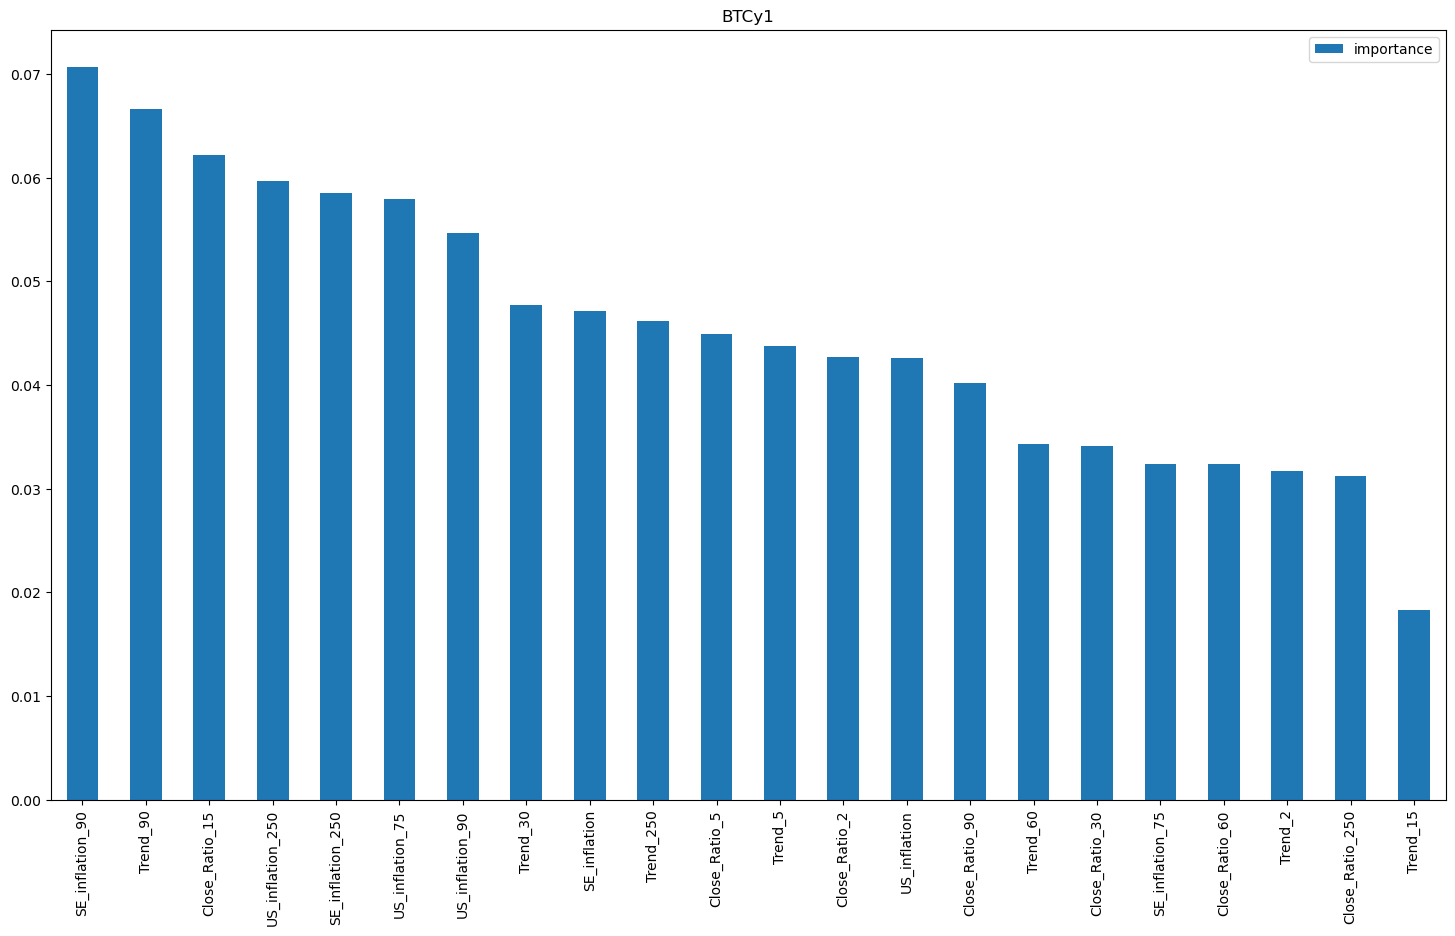

BTCy2
last date 2023-03-30
Fördelning av y2: 1 vs 0:
1.0    0.555676
0.0    0.444324
Name: y2, dtype: float64
y2   Predictions
1.0  0              922
0.0  0              773
1.0  1              610
0.0  1              452
dtype: int64
Precision o F1:	0.574388,	0.470316
target upp: 1532, pred upp: 1062, correct pred upp: 610, Precision: 0.5744
target ner: 1225, pred ner: 1695, correct pred ner: 773, Precision: 0.4560
Figure(1800x1000)


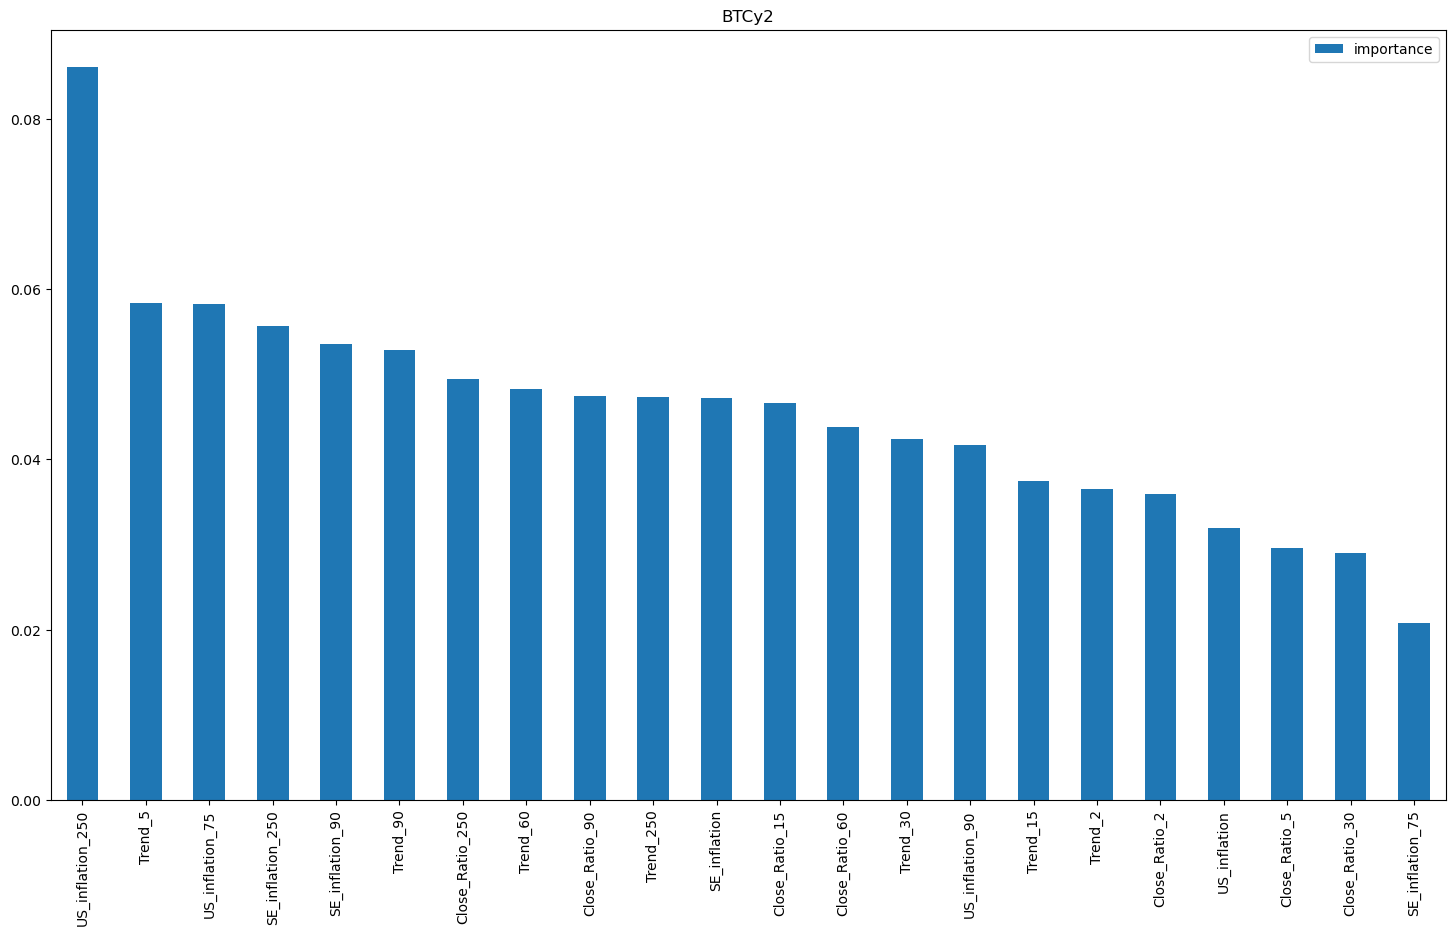

ETHy1
last date 2023-03-30
Fördelning av y1: 1 vs 0:
1.0    0.517713
0.0    0.482287
Name: y1, dtype: float64
y1   Predictions
1.0  0              629
0.0  0              617
1.0  1              204
0.0  1              159
dtype: int64
Precision o F1:	0.561983,	0.341137
target upp: 833, pred upp: 363, correct pred upp: 204, Precision: 0.5620
target ner: 776, pred ner: 1246, correct pred ner: 617, Precision: 0.4952
Figure(1800x1000)


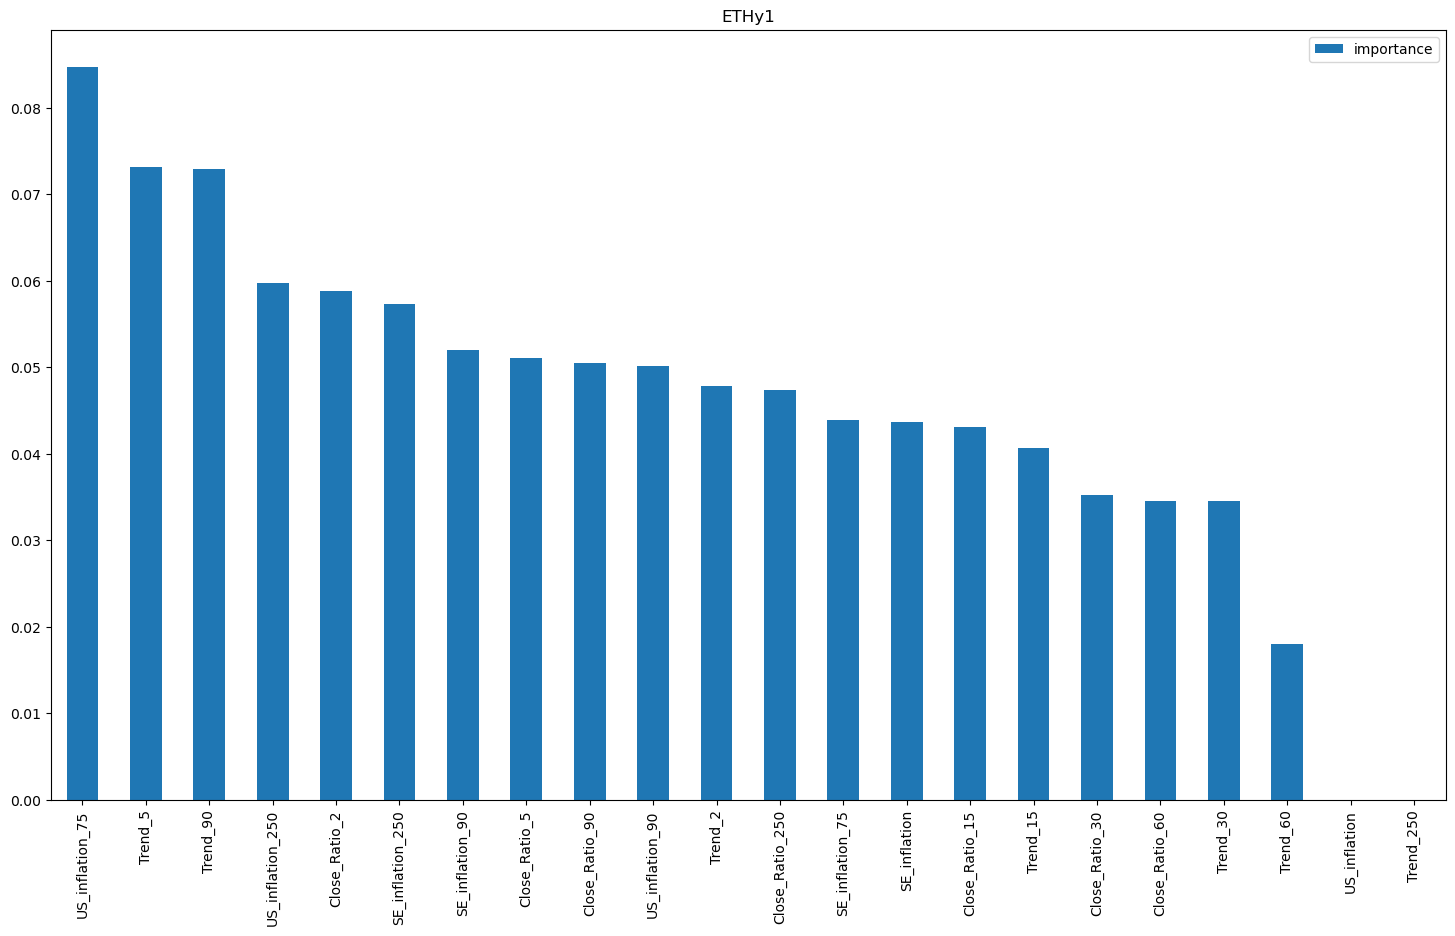

ETHy2
last date 2023-03-30
Fördelning av y2: 1 vs 0:
1.0    0.525171
0.0    0.474829
Name: y2, dtype: float64
y2   Predictions
1.0  0              555
0.0  0              511
1.0  1              290
0.0  1              253
dtype: int64
Precision o F1:	0.534070,	0.417867
target upp: 845, pred upp: 543, correct pred upp: 290, Precision: 0.5341
target ner: 764, pred ner: 1066, correct pred ner: 511, Precision: 0.4794
Figure(1800x1000)


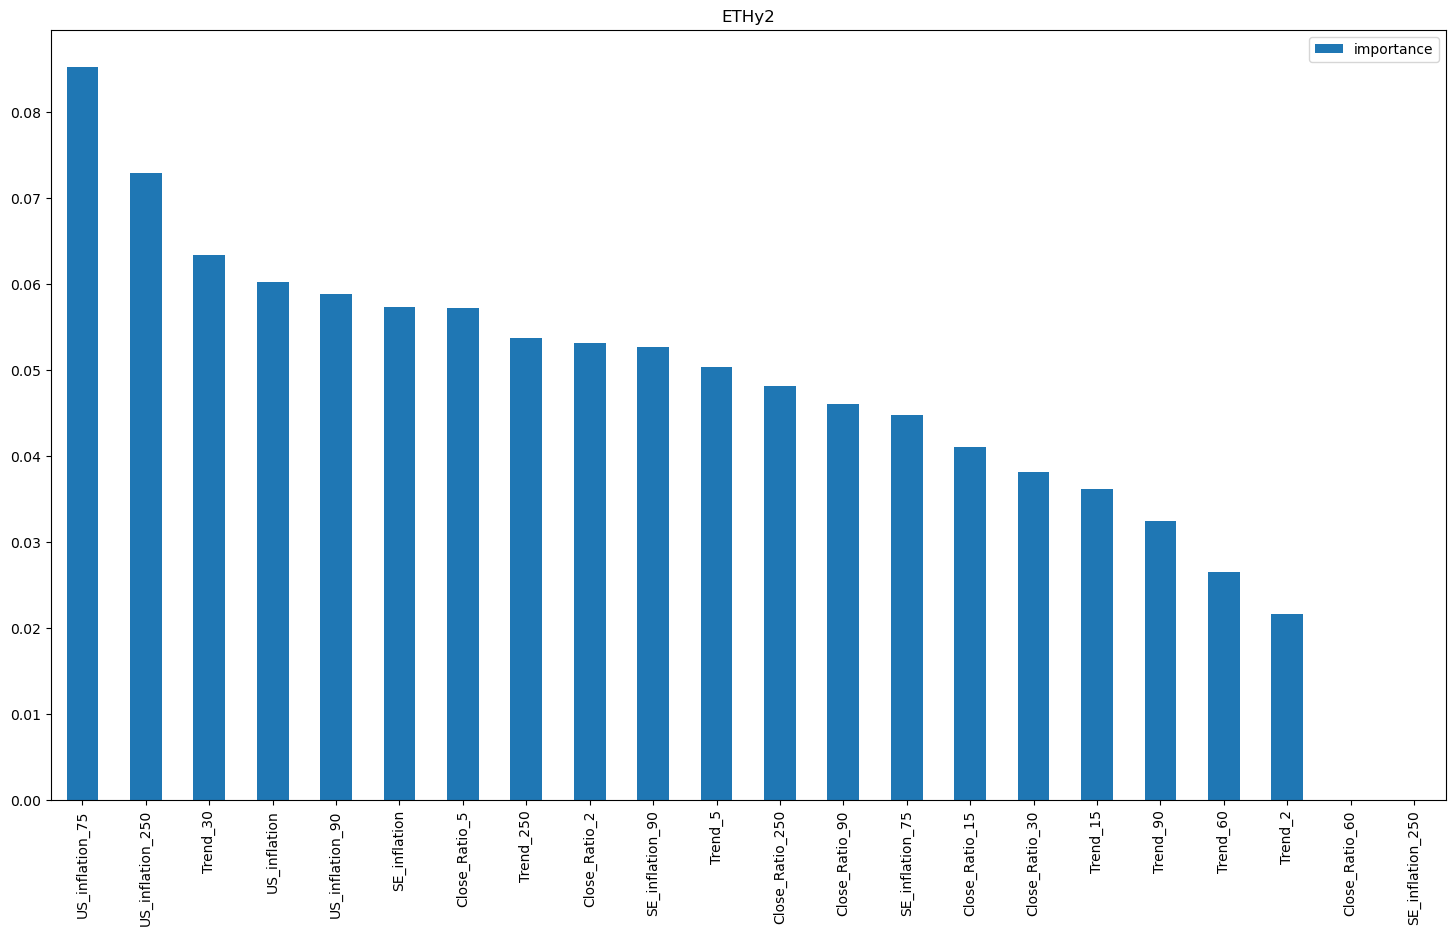

BCHy1
last date 2023-03-30
Fördelning av y1: 1 vs 0:
0.0    0.505283
1.0    0.494717
Name: y1, dtype: float64
y1   Predictions
0.0  0              655
1.0  0              628
     1              168
0.0  1              158
dtype: int64
Precision o F1:	0.515337,	0.299465
target upp: 796, pred upp: 326, correct pred upp: 168, Precision: 0.5153
target ner: 813, pred ner: 1283, correct pred ner: 655, Precision: 0.5105
Figure(1800x1000)


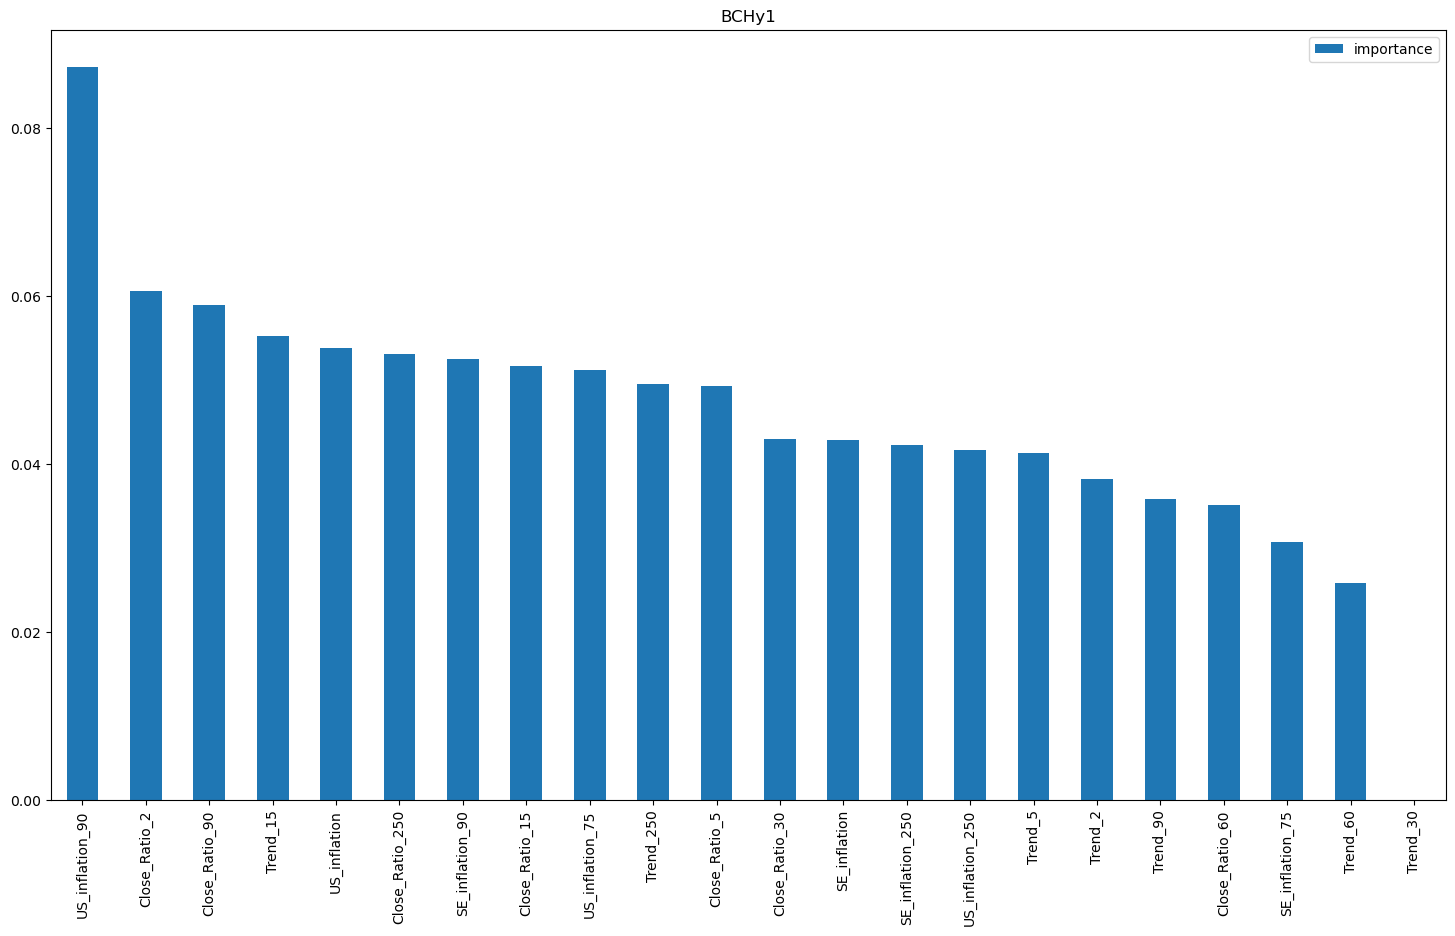

BCHy2
last date 2023-03-30
Fördelning av y2: 1 vs 0:
0.0    0.514605
1.0    0.485395
Name: y2, dtype: float64
y2   Predictions
0.0  0              680
1.0  0              614
     1              167
0.0  1              148
dtype: int64
Precision o F1:	0.530159,	0.304745
target upp: 781, pred upp: 315, correct pred upp: 167, Precision: 0.5302
target ner: 828, pred ner: 1294, correct pred ner: 680, Precision: 0.5255
Figure(1800x1000)


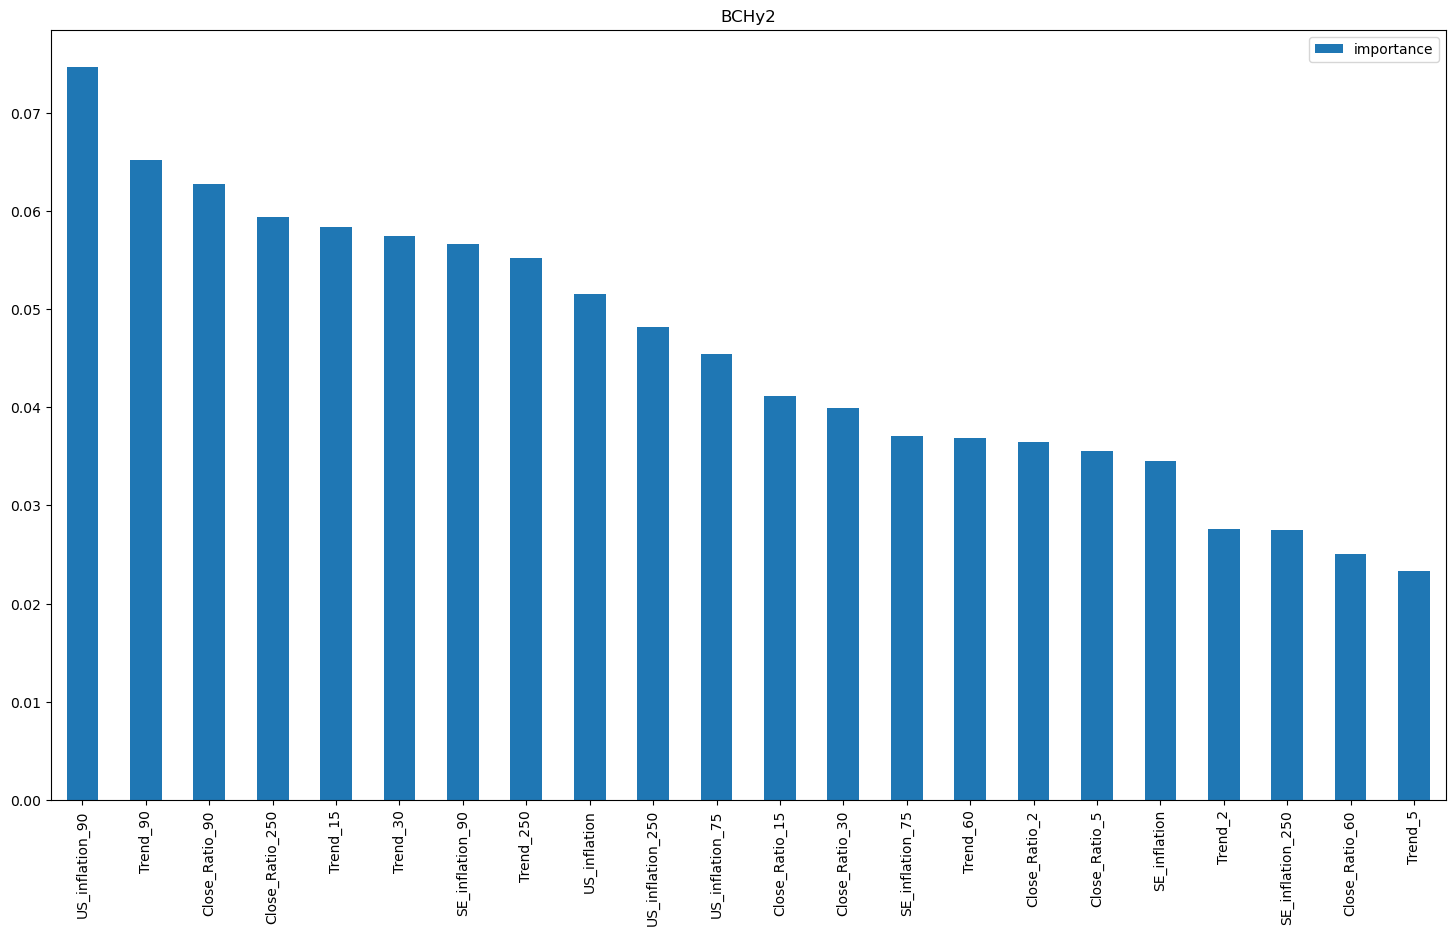

XRPy1
last date 2023-03-30
Fördelning av y1: 1 vs 0:
0.0    0.502797
1.0    0.497203
Name: y1, dtype: float64
y1   Predictions
0.0  0              676
1.0  0              610
     1              190
0.0  1              133
dtype: int64
Precision o F1:	0.588235,	0.338379
target upp: 800, pred upp: 323, correct pred upp: 190, Precision: 0.5882
target ner: 809, pred ner: 1286, correct pred ner: 676, Precision: 0.5257
Figure(1800x1000)


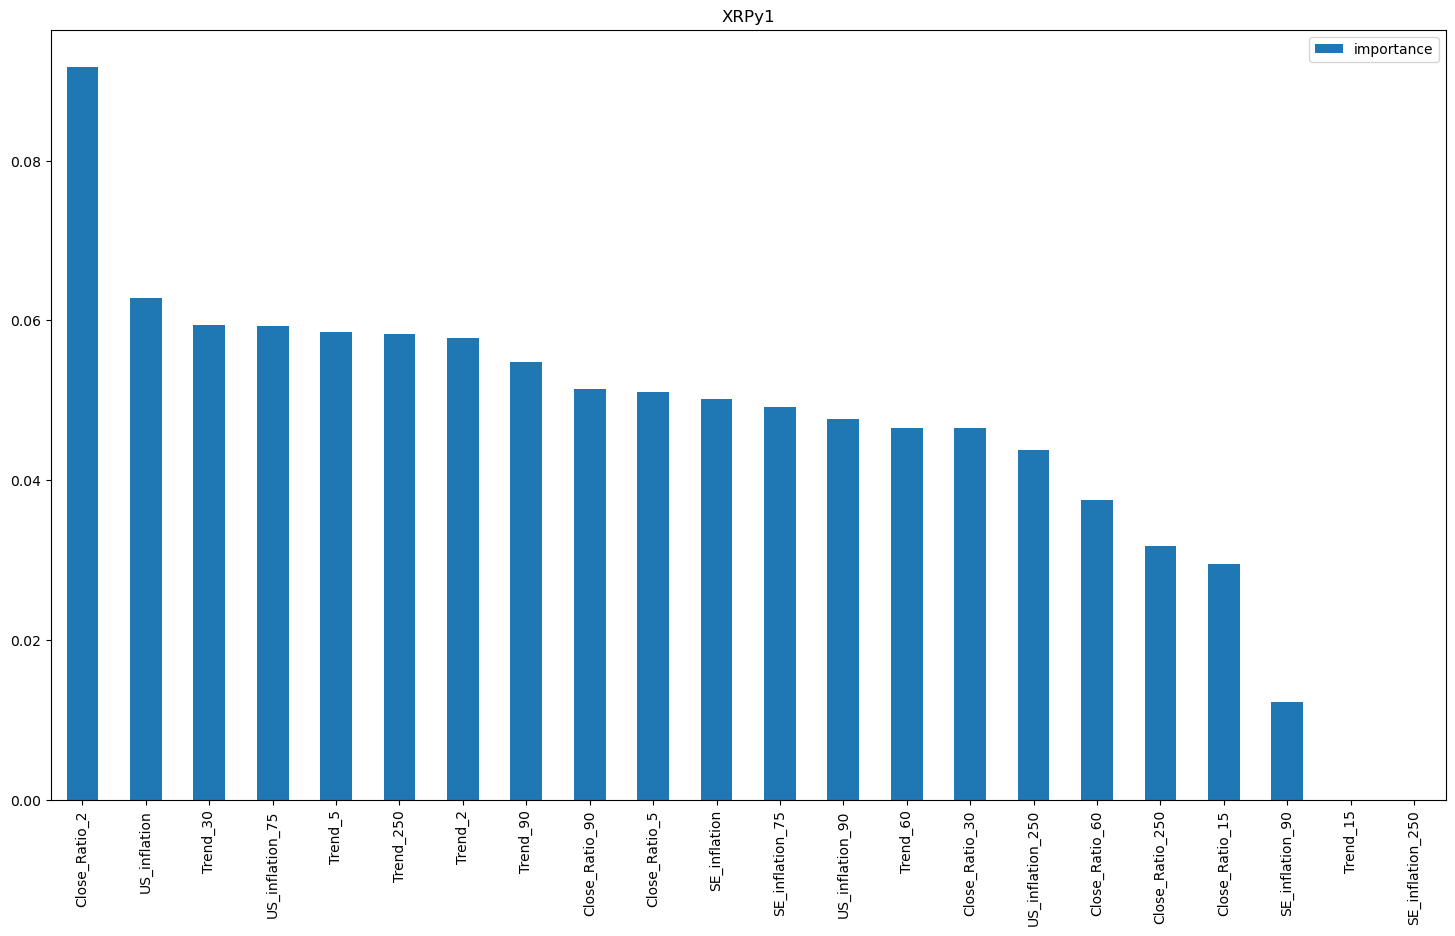

XRPy2
last date 2023-03-30
Fördelning av y2: 1 vs 0:
0.0    0.521442
1.0    0.478558
Name: y2, dtype: float64
y2   Predictions
0.0  0              692
1.0  0              632
0.0  1              147
1.0  1              138
dtype: int64
Precision o F1:	0.484211,	0.261611
target upp: 770, pred upp: 285, correct pred upp: 138, Precision: 0.4842
target ner: 839, pred ner: 1324, correct pred ner: 692, Precision: 0.5227
Figure(1800x1000)


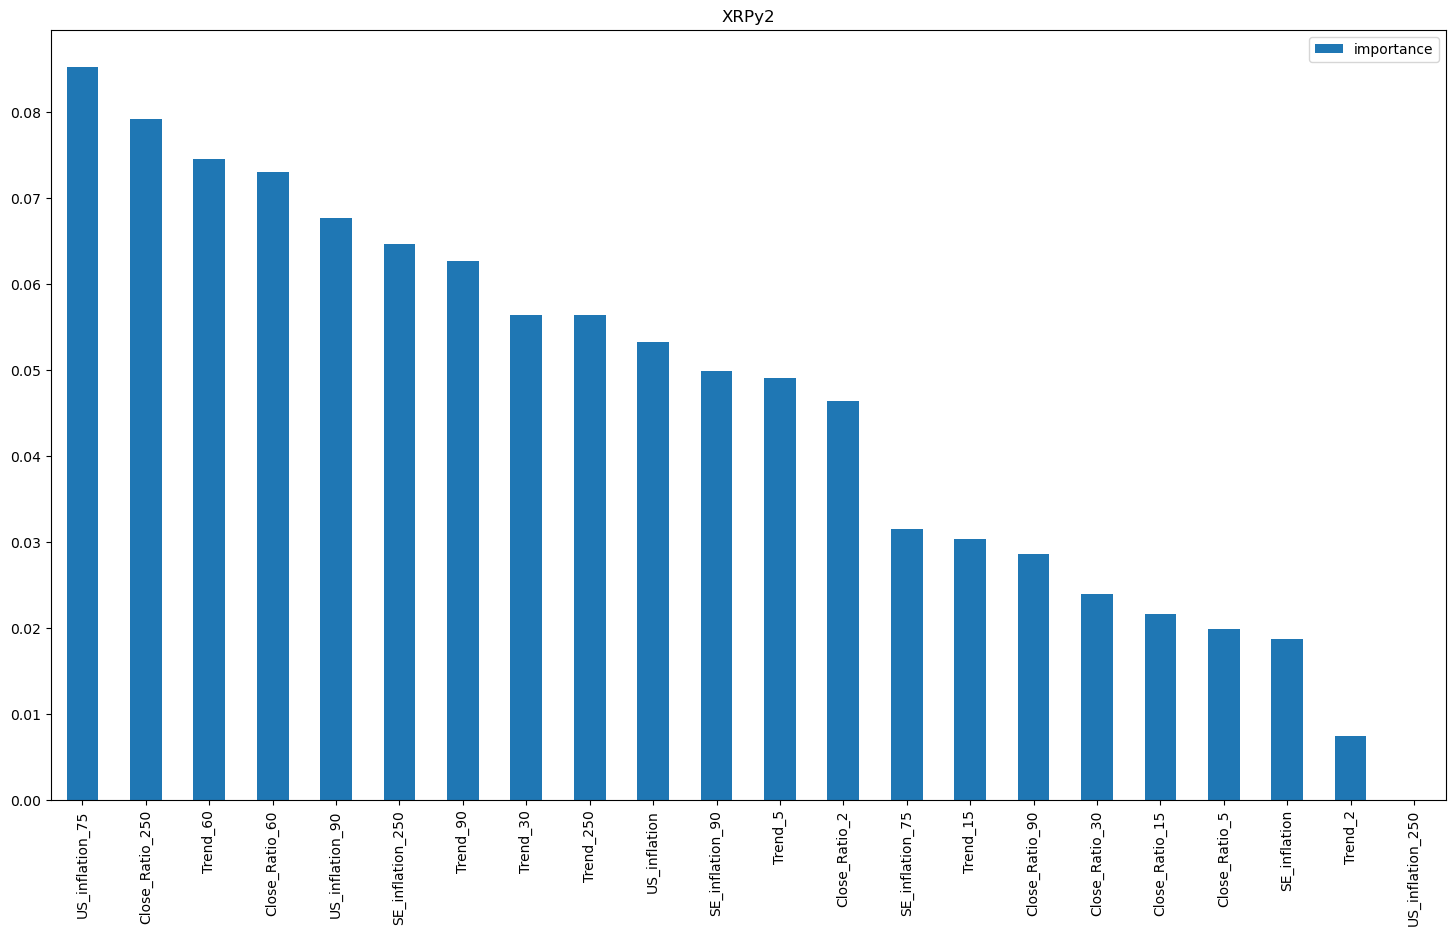

ZRXy1
last date 2023-03-30
Fördelning av y1: 1 vs 0:
0.0    0.504397
1.0    0.495603
Name: y1, dtype: float64
y1   Predictions
0.0  0              639
1.0  0              596
     1              193
0.0  1              164
dtype: int64
Precision o F1:	0.540616,	0.336824
target upp: 789, pred upp: 357, correct pred upp: 193, Precision: 0.5406
target ner: 803, pred ner: 1235, correct pred ner: 639, Precision: 0.5174
Figure(1800x1000)


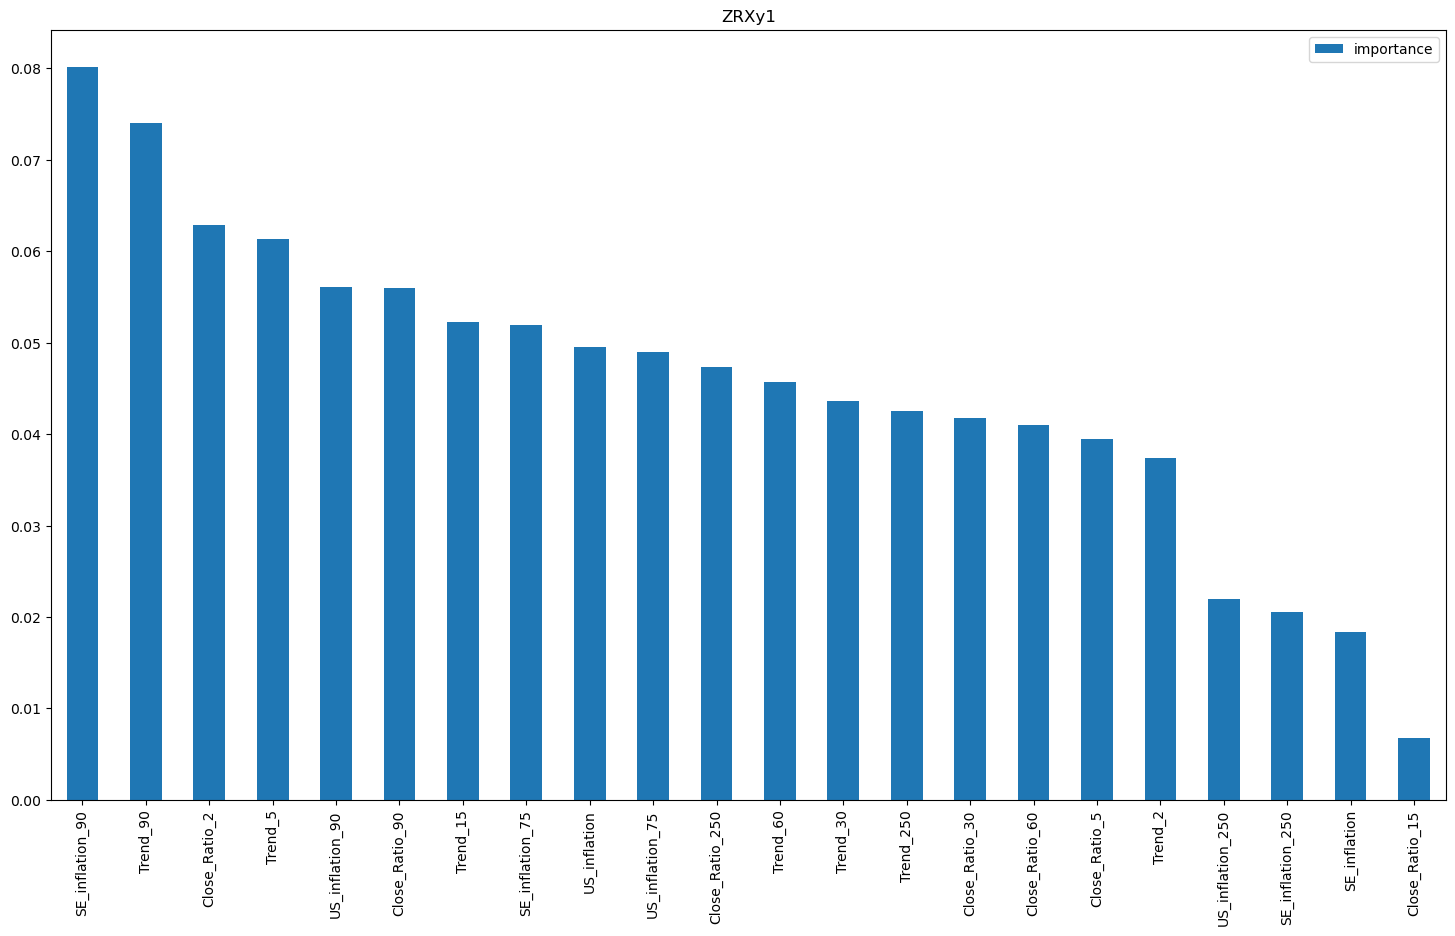

ZRXy2
last date 2023-03-30
Fördelning av y2: 1 vs 0:
0.0    0.523869
1.0    0.476131
Name: y2, dtype: float64
y2   Predictions
0.0  0              653
1.0  0              611
0.0  1              181
1.0  1              147
dtype: int64
Precision o F1:	0.448171,	0.270718
target upp: 758, pred upp: 328, correct pred upp: 147, Precision: 0.4482
target ner: 834, pred ner: 1264, correct pred ner: 653, Precision: 0.5166
Figure(1800x1000)


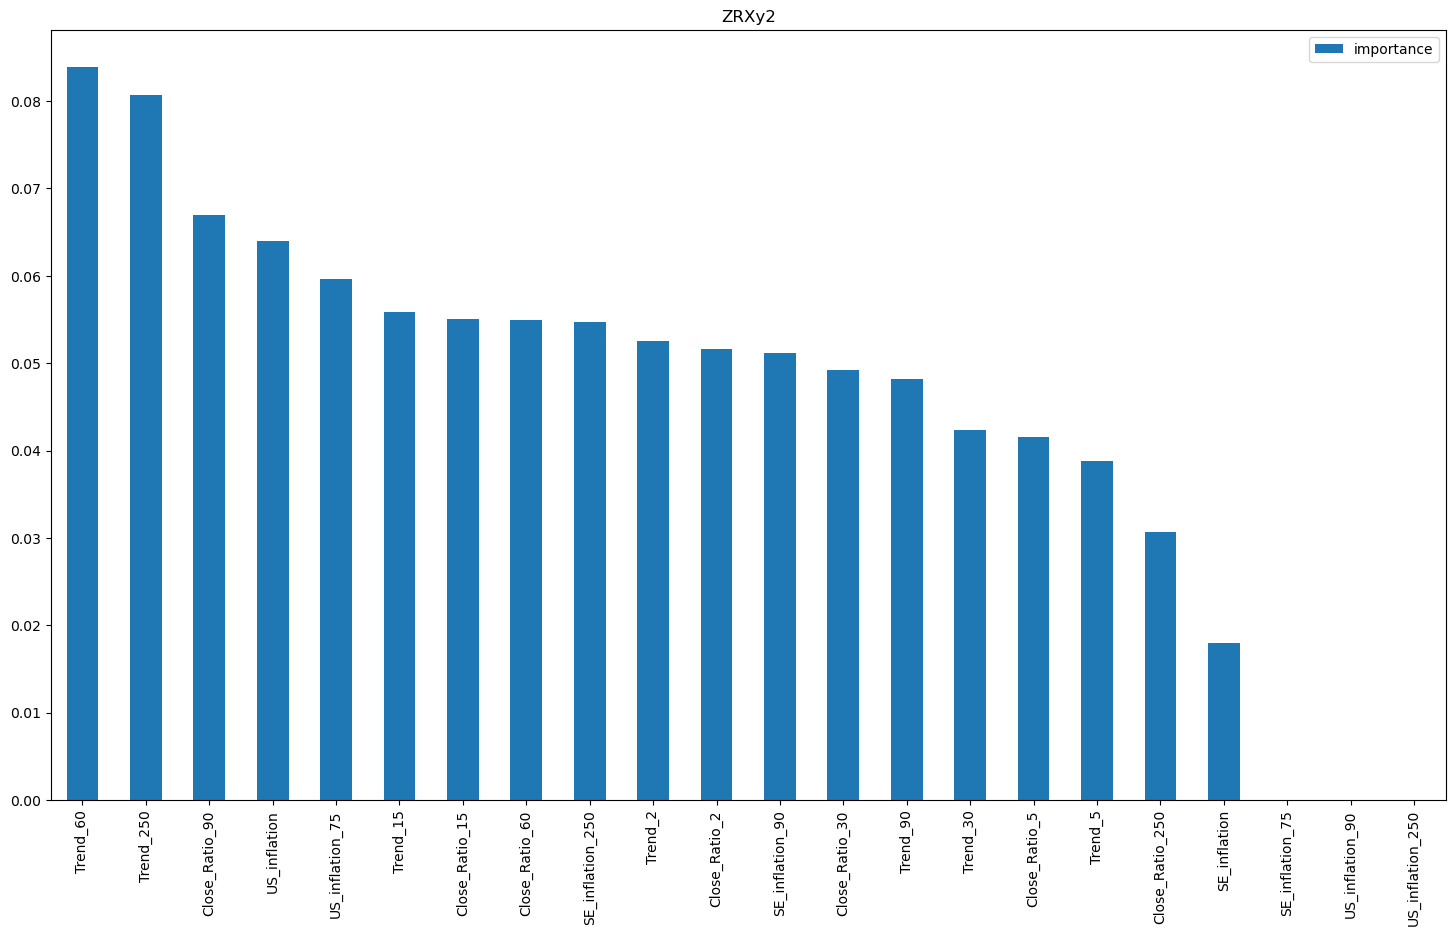

In [68]:
Modelltyp = 'xgb'
print(f'Kör med {Modelltyp}')
precision_list, predictors = generate_all_models(df_org, 
                                                tickers, 
                                                horizons = horizons,
                                                model_type = Modelltyp, 
                                                save=True, 
                                                remove = ['month', 'stoch_k', 'day_of_week', 'day_of_month'], 
                                                ETH_BTC = False, 
                                                use_inflations = True)


Grafer för uppåt och nedåt predictions

             F1
BTCy1  0.442157
BTCy2  0.470316
ETHy1  0.341137
ETHy2  0.417867
BCHy1  0.299465
BCHy2  0.304745
XRPy1  0.338379
XRPy2  0.261611
ZRXy1  0.336824
ZRXy2  0.270718


'bad precision xgb:'

,precision
XRPy2,0.484211
ZRXy2,0.448171


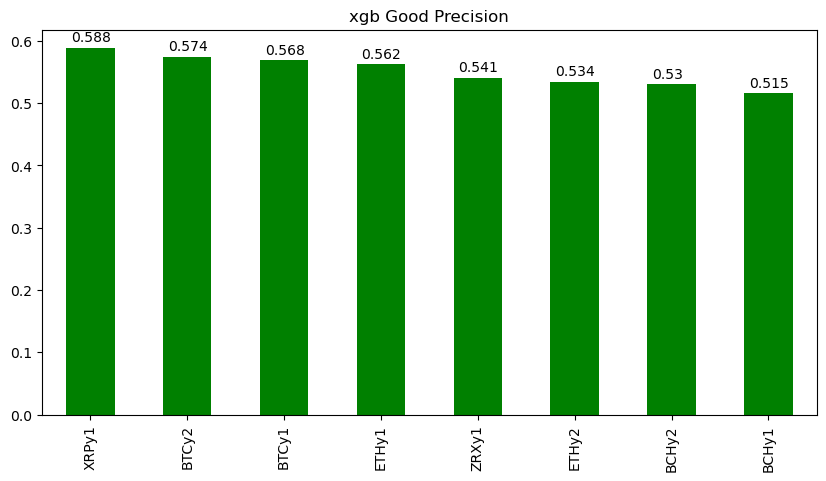

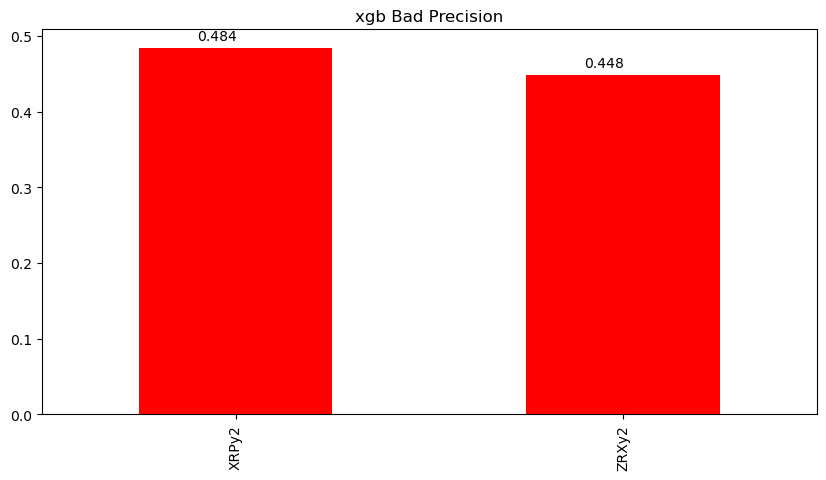

In [145]:
# TODO: GÖr om till graf av uppåt och neråt

p_d= dict([[x[0], x[1:]] for x in precision_list])
my_df = pd.DataFrame(p_d, index=['precision', 'F1']).T

print(my_df[['F1']])


df_precision = my_df[['precision']]
df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).plot(
                    kind='bar', figsize=(10,5), title = f'{Modelltyp} Good Precision', color='green', legend=False)
# plot values in bars
for i, v in enumerate(df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).values):
    plt.text(i-0.2, v+0.01, str(round(v[0],3)))
try:
    df_precision.query('precision <= 0.5').sort_values(by='precision', ascending=False).plot(
                       kind='bar',  figsize=(10, 5), title=f'{Modelltyp} Bad Precision', color='red', legend=False)
    # plot values in bars
    for i, v in enumerate(df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).values):
        plt.text(i-0.1, v+0.01, str(round(v[0],3)))
except IndexError:
    print('No bad precision!')

display(f'bad precision {Modelltyp}:',df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False))
df_precision.to_csv('precision_lags_and_ratio_no_month_stochk_15_90.csv')
# df

In [130]:
# plocka ut det första värdet i varje element i listan precision_list
d= dict([[x[0], x[1:]] for x in precision_list])
my_df = pd.DataFrame(d, index=['precision', 'F1']).T
my_df


{'BTCy1': (0.5682539682539682, 0.44215726636475916), 'BTCy2': (0.5743879472693032, 0.4703161141094834), 'ETHy1': (0.5619834710743802, 0.34113712374581945), 'ETHy2': (0.5340699815837937, 0.4178674351585014), 'BCHy1': (0.5153374233128835, 0.2994652406417112), 'BCHy2': (0.5301587301587302, 0.30474452554744524), 'XRPy1': (0.5882352941176471, 0.33837934105075695), 'XRPy2': (0.4842105263157895, 0.2616113744075829), 'ZRXy1': (0.5406162464985994, 0.3368237347294939), 'ZRXy2': (0.4481707317073171, 0.27071823204419887)}


,precision,F1
BTCy1,0.568254,0.442157
BTCy2,0.574388,0.470316
ETHy1,0.561983,0.341137
ETHy2,0.534070,0.417867
BCHy1,0.515337,0.299465
BCHy2,0.530159,0.304745
XRPy1,0.588235,0.338379
XRPy2,0.484211,0.261611
ZRXy1,0.540616,0.336824
ZRXy2,0.448171,0.270718


# Skapa en GridSearchCV för XGBoost och CatBoost

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [ ]:
### get the data ###
df_grid = get_all(tickers)
df_inflations = get_inflation_data(graph=False)

In [ ]:
### preprocessing ###
# Vi gör GridSearch för enbart en kryptovaluta i taget. Vi väljer BTC och ETH.
ticker = tickers[1]
print(ticker)
target='y1'  # tomorrow
df, predictors = create_predictors(df_grid, ticker, target, horizons=horizons, ETH_BTC=False)

# inflation data #
df = pd.concat([df, df_inflations], axis=1)
df.dropna(subset=['Tomorrow'], inplace=True)
df.dropna(subset=[target], inplace=True)

print(df[['Tomorrow']].values > df[[ticker]].values)
print(df.shape)


In [ ]:
predictors = ['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_15',
       'Trend_15', 'Close_Ratio_30', 'Trend_30', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_90', 'Trend_90', 'Close_Ratio_250', 'Trend_250', 'US_inflation',
       'SE_inflation', 'US_inflation_75', 'SE_inflation_75', 'US_inflation_90', 'SE_inflation_90', 'US_inflation_250', 'SE_inflation_250']

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
y = df['y1']
X = df.drop('y1', axis=1)

# split_index is the row-index that splits the data into 75% for training and 25% for testing
split_index = int(0.9 * len(df))

# split the data into training and testing sets
X_train = X.iloc[:split_index, :]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:, :]
y_test = y.iloc[split_index:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
params_xgb = {
    'max_depth': [ 3, 4, 5],
    'n_estimators': [ 50, 100, 150],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15]
}

params_cat = {
    'depth': [7, 10, 12 ],
    'iterations': [ 30, 50, 100],
    'learning_rate': [0.01, 0.03, 0.05, 0.1]
}


In [ ]:
### GridSearchCV  ###
if True:
    xgb = XGBClassifier()
    grid_xgb = GridSearchCV(estimator=xgb, param_grid=params_xgb, n_jobs=-1, pre_dispatch='2*n_jobs', cv=tscv, 
                            scoring=['roc_auc', 'neg_log_loss', 'precision', 'f1'], refit='roc_auc', verbose=0)
    grid_xgb.fit(X_train[predictors], y_train)
print('xgb',grid_xgb.best_score_, grid_xgb.best_params_)

if True:
    cat = CatBoostClassifier()
    grid_cat = GridSearchCV(estimator=cat, param_grid=params_cat, n_jobs=-1,pre_dispatch='2*n_jobs', cv=tscv, # type: ignore
                             scoring=['roc_auc', 'neg_log_loss', 'precision', 'f1'], refit='roc_auc',verbose=0) 
    grid_cat.fit(X_train[predictors], y_train) 
print('cat',grid_cat.best_score_, grid_cat.best_params_)

In [ ]:
# sorted(sklearn.metrics.SCORERS.keys())
print(grid_xgb.best_score_, grid_xgb.best_index_ , grid_xgb.best_params_)
print(grid_cat.best_score_, grid_cat.best_index_ , grid_cat.best_params_)

In [ ]:
import sklearn.metrics

def log_loss(y_true, y_pred):
    return sklearn.metrics.log_loss(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None) 

y_pred_xgb = grid_xgb.predict(X_test[predictors])
y_pred_cat = grid_cat.predict(X_test[predictors])

dict1 = {"XGBoost": {'f1':f1_score(y_test, y_pred_xgb), 'AUC': roc_auc_score(y_test, y_pred_xgb), 
                     'precision': precision_score(y_test, y_pred_xgb), 'recall': recall_score(y_test, y_pred_xgb),
                     'log_loss': log_loss(y_test, y_pred_xgb)},
         "catboost":{'f1':f1_score(y_test, y_pred_cat), 'AUC': roc_auc_score(y_test, y_pred_cat), 
         'precision': precision_score(y_test, y_pred_cat), 'recall': recall_score(y_test, y_pred_cat),
         'log_loss': log_loss(y_test, y_pred_cat)}}
print(pd.DataFrame(dict1))


In [ ]:
pd.DataFrame(dict1).to_csv(ticker[:3]+'_output.csv',index=True)

BTC:  
- XGB: 0.5198207468963943 9 {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 50}  
- CAT: 0.5362153381013091 15 {'depth': 10, 'iterations': 30, 'learning_rate': 0.1}  
  
ETH:  
- XGB: 0.5427315401213113 4 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}  
- CAT: 0.5477744412767092 25 {'depth': 12, 'iterations': 30, 'learning_rate': 0.03}  
     
Slutsats:     
__CatBoost__ är möjligen bättre än XGBoost för de flesta score för BTC men inte lika tydligt för ETH

# Bryt här. Det finns ett plotly-exempel sist

Kollar TimeSeriesSplit Cross Validation  
Jag gillar min egen backtest-variant bätte   
- Den har start vilket garanterar att första Train-datat inte är för litet  
- Den har step-size i stället för n_splits vilka ger samma index-värden om så önskas  
- Båda har gap 

In [ ]:
horizons=[2,5,15,30,60,90,250]
df, predictors = create_predictors(df_org, tickers[0], 'y1', horizons=horizons)
# df, predictors = add_google_trends(df, df_trend, tickers[0], predictors)

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10,gap=1)
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index[0], '-', train_index[-1], "\nTEST:", test_index[0], '-', test_index[-1])
    # X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    # y_train, y_test = df.iloc[train_index], df.iloc[test_index]


### Test plotly

In [ ]:
df.columns 

In [ ]:
df[['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD','Tomorrow','After_tomorrow', 'Trend_2', 'Trend_5', 'Close_Ratio_2']]

In [ ]:
# compute relative development
def rel_dev(df_ticker_):
    df_ticker = df_ticker_.copy()
    df_ticker = df_ticker/df_ticker.shift(1)-1
    df_ticker = df_ticker.dropna()
    just = df_ticker.head(1).values[0]
    df_ticker -= just
    return df_ticker

BTC = df[['BTC-USD']].query('index >= "2022-01-01"'); ETH = df[['ETH-USD']].query('index >= "2022-01-01"'); BCH = df[['BCH-USD']].query('index >= "2022-01-01"'); ZRX = df[['ZRX-USD']].query('index >= "2022-01-01"'); XRP = df[['XRP-USD']].query('index >= "2022-01-01"')

BTC = rel_dev(BTC)
ETH = rel_dev(ETH)
BCH = rel_dev(BCH)
ZRX = rel_dev(ZRX)
XRP = rel_dev(XRP)
# share x-axis

comb = pd.concat([BTC,ETH,BCH,ZRX,XRP],axis=1,)
# plot comb
comb.plot(figsize=(10,5), title='Relative Development of crypto', color=['red','green','blue','orange','purple'])
# share the same x-axis
plt.show()
display(comb.tail())

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Assuming 'comb' is a DataFrame with the index as the x-axis values
x_values = comb.index

# Create a plotly line chart
fig = go.Figure()

# Add lines for each cryptocurrency with custom colors
fig.add_trace(go.Scatter(
    x=x_values, y=comb['BTC-USD'], mode='lines', name='BTC-USD', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['ETH-USD'], mode='lines', name='ETH-USD', line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['BCH-USD'], mode='lines', name='BCH-USD', line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['ZRX-USD'], mode='lines', name='ZRX-USD', line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['XRP-USD'], mode='lines', name='XRP-USD', line=dict(color='purple', width=2)))

# Set the chart title
fig.update_layout(title='Price')

# Set the chart size
fig.update_layout(height=800, width=1000)

fig.show()
